Credits to:
1. Hugging-face
2. Prof. Kaikai Liu
3. Internet

#Installing libraries

In [46]:
!pip install transformers matplotlib datasets evaluate seaborn rouge-score bert-score sacrebleu gradio

#Importing libraries and dataset

In [47]:
from datasets import load_dataset
from transformers import pipeline
from rouge_score import rouge_scorer
from bert_score import score as bert_score
import matplotlib.pyplot as plt
import gradio as gr
from sacrebleu import corpus_bleu
from datasets import load_dataset
import warnings
warnings.filterwarnings("ignore")

dataset = load_dataset("csebuetnlp/xlsum", "english")



In [48]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'title', 'summary', 'text'],
        num_rows: 306522
    })
    test: Dataset({
        features: ['id', 'url', 'title', 'summary', 'text'],
        num_rows: 11535
    })
    validation: Dataset({
        features: ['id', 'url', 'title', 'summary', 'text'],
        num_rows: 11535
    })
})

# Using hugging-face pipelines for inference

In [49]:
facebook_cnn_pipe = pipeline("summarization", model="facebook/bart-large-cnn")
distilbart_pipe = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")
google_pipe = pipeline("summarization", model="google/bigbird-pegasus-large-bigpatent")



In [50]:
sample_text = dataset['test'][0]['text']
reference_summary = dataset['test'][0]['summary']
print("Original text: ",sample_text)
print("-----------------------")
print("Original summary: ",reference_summary)
print("-----------------------")
facebook_summary = facebook_cnn_pipe(sample_text)
print("Facebook: ", facebook_summary)
print("-----------------------")
distill_summary = distilbart_pipe(sample_text)
print("Distill: ", distill_summary)
print("-----------------------")
google_summary = google_pipe(sample_text)
print("Google: ", google_summary)
print("-----------------------")



Original text:  By Kate DaileyBBC News Earlier this week, Trump posted a photo of himself sitting at a desk at Mar-a-Largo, a permanent marker hovering over a notepad. "Writing my inaugural address at the Winter White House, Mar-a-Lago, three weeks ago. Looking forward to Friday," he tweeted. Trump vows to end 'American carnage' Trump's angry call to arms Full text of Trump's inauguration speech It's unclear whether the president-elect actually wrote the speech himself, but the content was pure Trump: the same populist message that resonated throughout the primaries and the campaign. "Today, we are not merely transferring power from one administration to another, or from one party to another, but we are transferring power from Washington, DC, and giving it back to you, the people," he said at the beginning of his remarks. For some on Twitter, it bore an eerie similarity to the Batman villain Bane's speech in The Dark Night Rises, so much so that someone posted a 10-second mash-up of th

# Rouge Score

In [51]:
def calculate_rouge(model_summary, reference):
  scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL', 'rougeLsum'], use_stemmer=True)
  return scorer.score(reference, model_summary[0]['summary_text'])

facebook_rouge = calculate_rouge(facebook_summary, reference_summary)
distill_rouge = calculate_rouge(distill_summary, reference_summary)
google_rouge = calculate_rouge(google_summary, reference_summary)
print(facebook_rouge)
print("---------------------")
print(distill_rouge)
print("---------------------")
print(google_rouge)

{'rouge1': Score(precision=0.1836734693877551, recall=0.391304347826087, fmeasure=0.25), 'rouge2': Score(precision=0.041666666666666664, recall=0.09090909090909091, fmeasure=0.05714285714285715), 'rougeL': Score(precision=0.10204081632653061, recall=0.21739130434782608, fmeasure=0.1388888888888889), 'rougeLsum': Score(precision=0.10204081632653061, recall=0.21739130434782608, fmeasure=0.1388888888888889)}
---------------------
{'rouge1': Score(precision=0.1509433962264151, recall=0.34782608695652173, fmeasure=0.2105263157894737), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07547169811320754, recall=0.17391304347826086, fmeasure=0.10526315789473685), 'rougeLsum': Score(precision=0.07547169811320754, recall=0.17391304347826086, fmeasure=0.10526315789473685)}
---------------------
{'rouge1': Score(precision=0.021551724137931036, recall=0.21739130434782608, fmeasure=0.03921568627450981), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'ro

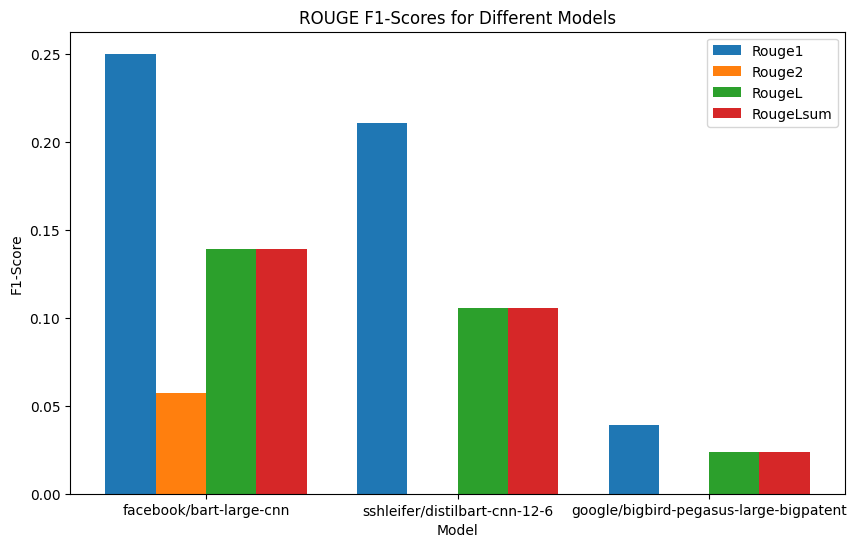

In [52]:
import matplotlib.pyplot as plt

# Assuming you have the scores stored in a list of dictionaries
scores = [
    facebook_rouge,
    distill_rouge,
    google_rouge
]

# Extract F1-scores for each model and metric
f1_scores = []
for score_dict in scores:
    f1_scores.append([score.fmeasure for score in score_dict.values()])

# Model names
model_names = ['facebook/bart-large-cnn', 'sshleifer/distilbart-cnn-12-6', 'google/bigbird-pegasus-large-bigpatent']  # Replace with actual model names

# Create the bar chart
x = range(len(model_names))
width = 0.2

plt.figure(figsize=(10, 6))
plt.bar(x, [f1[0] for f1 in f1_scores], width, label='Rouge1')
plt.bar([x_i + width for x_i in x], [f1[1] for f1 in f1_scores], width, label='Rouge2')
plt.bar([x_i + 2*width for x_i in x], [f1[2] for f1 in f1_scores], width, label='RougeL')
plt.bar([x_i + 3*width for x_i in x], [f1[3] for f1 in f1_scores], width, label='RougeLsum')

plt.xticks([x_i + 1.5*width for x_i in x], model_names)
plt.ylabel('F1-Score')
plt.xlabel('Model')
plt.title('ROUGE F1-Scores for Different Models')
plt.legend()
plt.show()

# BERT Score

In [53]:
def calculate_bert_score(model_summary, reference_summary):
  return bert_score([model_summary[0]['summary_text']], [reference_summary], lang="en")[2]

In [54]:
bert_facebook = calculate_bert_score(facebook_summary, reference_summary)
bert_distill = calculate_bert_score(distill_summary, reference_summary)
bert_google = calculate_bert_score(google_summary, reference_summary)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
print("facbook bert: ", bert_facebook)
print("Distill bert: ", bert_distill)
print("Google bert: ", bert_google)

facbook bert:  tensor([0.8593])
Distill bert:  tensor([0.8434])
Google bert:  tensor([0.7878])


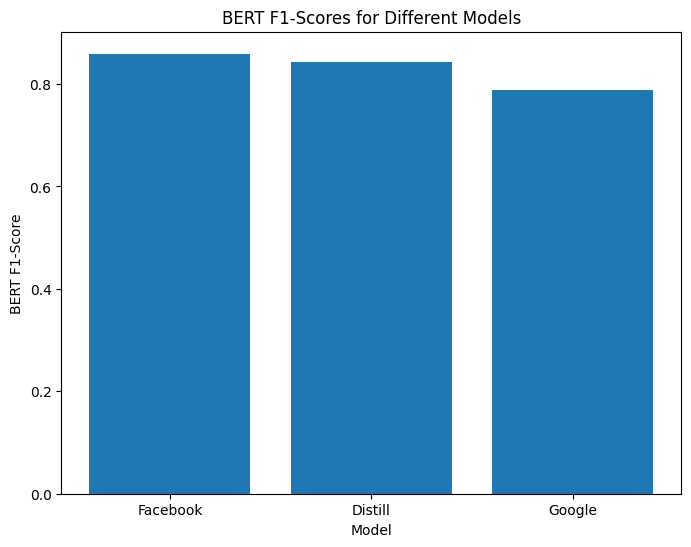

In [56]:
import matplotlib.pyplot as plt
bert_scores = [
    bert_facebook.item(),
    bert_distill.item(),
    bert_google.item()
]
model_names = ['Facebook', 'Distill', 'Google']

plt.figure(figsize=(8, 6))
plt.bar(model_names, bert_scores)
plt.xlabel('Model')
plt.ylabel('BERT F1-Score')
plt.title('BERT F1-Scores for Different Models')
plt.show()

# Bleu Score

In [57]:

import evaluate
bleu = evaluate.load("bleu")
def calculate_bleu_score(model_summary, reference_summary):
  return corpus_bleu([model_summary[0]['summary_text']], [[reference_summary]]).score

bleu_facebook = calculate_bleu_score(facebook_summary, reference_summary)
bleu_distill = calculate_bleu_score(distill_summary, reference_summary)
bleu_google = calculate_bleu_score(google_summary, reference_summary)

print("facbook bleu: ", bleu_facebook)
print("Distill bleu: ", bleu_distill)
print("Google bleu: ", bleu_google)

facbook bleu:  1.052601808414082
Distill bleu:  1.0363935070930819
Google bleu:  0.20790245444365657


# Averaging the scores, given multiple rows

Only 5 rows from the dataset were used here because I was running out of memory on Google Colab. So 5 were used to be on the safer side.

In [71]:
table = []
for i in range(5):
    sample_text = dataset['test'][i]['text']
    reference_summary = dataset['test'][i]['summary']

    facebook_summary = facebook_cnn_pipe(sample_text)
    distill_summary = distilbart_pipe(sample_text)
    google_summary = google_pipe(sample_text)

    facebook_rouge = calculate_rouge(facebook_summary, reference_summary)
    distill_rouge = calculate_rouge(distill_summary, reference_summary)
    google_rouge = calculate_rouge(google_summary, reference_summary)
    print(facebook_rouge)
    print(distill_rouge)
    print(google_rouge)
    bert_facebook = calculate_bert_score(facebook_summary, reference_summary)
    bert_distill = calculate_bert_score(distill_summary, reference_summary)
    bert_google = calculate_bert_score(google_summary, reference_summary)
    print(bert_facebook, bert_distill, bert_google)
    # result.append([facebook_rouge, distill_rouge, google_rouge])
    table.append({
        'Model': 'Facebook',
        'ROUGE-1': facebook_rouge['rouge1'].fmeasure,
        'ROUGE-2': facebook_rouge['rouge2'].fmeasure,
        'ROUGE-L': facebook_rouge['rougeL'].fmeasure,
        'BERTScore F1': bert_facebook,
    })
    table.append({
        'Model': 'Distill',
        'ROUGE-1': distill_rouge['rouge1'].fmeasure,
        'ROUGE-2': distill_rouge['rouge2'].fmeasure,
        'ROUGE-L': distill_rouge['rougeL'].fmeasure,
        'BERTScore F1': bert_distill,
    })
    table.append({
        'Model': 'Google',
        'ROUGE-1': google_rouge['rouge1'].fmeasure,
        'ROUGE-2': google_rouge['rouge2'].fmeasure,
        'ROUGE-L': google_rouge['rougeL'].fmeasure,
        'BERTScore F1': bert_google,
    })

{'rouge1': Score(precision=0.1836734693877551, recall=0.391304347826087, fmeasure=0.25), 'rouge2': Score(precision=0.041666666666666664, recall=0.09090909090909091, fmeasure=0.05714285714285715), 'rougeL': Score(precision=0.10204081632653061, recall=0.21739130434782608, fmeasure=0.1388888888888889), 'rougeLsum': Score(precision=0.10204081632653061, recall=0.21739130434782608, fmeasure=0.1388888888888889)}
{'rouge1': Score(precision=0.1509433962264151, recall=0.34782608695652173, fmeasure=0.2105263157894737), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.07547169811320754, recall=0.17391304347826086, fmeasure=0.10526315789473685), 'rougeLsum': Score(precision=0.07547169811320754, recall=0.17391304347826086, fmeasure=0.10526315789473685)}
{'rouge1': Score(precision=0.15625, recall=0.21739130434782608, fmeasure=0.18181818181818182), 'rouge2': Score(precision=0.03225806451612903, recall=0.045454545454545456, fmeasure=0.03773584905660377), 'rougeL': S

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor([0.8593]) tensor([0.8434]) tensor([0.8457])
{'rouge1': Score(precision=0.16393442622950818, recall=0.3448275862068966, fmeasure=0.22222222222222224), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08196721311475409, recall=0.1724137931034483, fmeasure=0.11111111111111112), 'rougeLsum': Score(precision=0.08196721311475409, recall=0.1724137931034483, fmeasure=0.11111111111111112)}
{'rouge1': Score(precision=0.26229508196721313, recall=0.5517241379310345, fmeasure=0.35555555555555557), 'rouge2': Score(precision=0.1, recall=0.21428571428571427, fmeasure=0.13636363636363638), 'rougeL': Score(precision=0.13114754098360656, recall=0.27586206896551724, fmeasure=0.17777777777777778), 'rougeLsum': Score(precision=0.13114754098360656, recall=0.27586206896551724, fmeasure=0.17777777777777778)}
{'rouge1': Score(precision=0.19047619047619047, recall=0.27586206896551724, fmeasure=0.22535211267605634), 'rouge2': Score(precision=0.024390243902439025, recall

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor([0.8621]) tensor([0.8686]) tensor([0.8338])
{'rouge1': Score(precision=0.08, recall=0.2222222222222222, fmeasure=0.11764705882352941), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.06, recall=0.16666666666666666, fmeasure=0.08823529411764705), 'rougeLsum': Score(precision=0.06, recall=0.16666666666666666, fmeasure=0.08823529411764705)}
{'rouge1': Score(precision=0.07894736842105263, recall=0.16666666666666666, fmeasure=0.10714285714285714), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.05263157894736842, recall=0.1111111111111111, fmeasure=0.07142857142857142), 'rougeLsum': Score(precision=0.05263157894736842, recall=0.1111111111111111, fmeasure=0.07142857142857142)}
{'rouge1': Score(precision=0.1875, recall=0.3333333333333333, fmeasure=0.24000000000000005), 'rouge2': Score(precision=0.03225806451612903, recall=0.058823529411764705, fmeasure=0.041666666666666664), 'rougeL': Score(precision=0.1875, re

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor([0.8489]) tensor([0.8341]) tensor([0.8863])
{'rouge1': Score(precision=0.22641509433962265, recall=0.5, fmeasure=0.31168831168831174), 'rouge2': Score(precision=0.038461538461538464, recall=0.08695652173913043, fmeasure=0.05333333333333333), 'rougeL': Score(precision=0.1320754716981132, recall=0.2916666666666667, fmeasure=0.18181818181818182), 'rougeLsum': Score(precision=0.1320754716981132, recall=0.2916666666666667, fmeasure=0.18181818181818182)}
{'rouge1': Score(precision=0.22641509433962265, recall=0.5, fmeasure=0.31168831168831174), 'rouge2': Score(precision=0.07692307692307693, recall=0.17391304347826086, fmeasure=0.10666666666666666), 'rougeL': Score(precision=0.1320754716981132, recall=0.2916666666666667, fmeasure=0.18181818181818182), 'rougeLsum': Score(precision=0.1320754716981132, recall=0.2916666666666667, fmeasure=0.18181818181818182)}
{'rouge1': Score(precision=0.1368421052631579, recall=0.5416666666666666, fmeasure=0.2184873949579832), 'rouge2': Score(precision=0.

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor([0.8690]) tensor([0.8638]) tensor([0.8490])
{'rouge1': Score(precision=0.14035087719298245, recall=0.26666666666666666, fmeasure=0.1839080459770115), 'rouge2': Score(precision=0.03571428571428571, recall=0.06896551724137931, fmeasure=0.047058823529411764), 'rougeL': Score(precision=0.08771929824561403, recall=0.16666666666666666, fmeasure=0.11494252873563217), 'rougeLsum': Score(precision=0.08771929824561403, recall=0.16666666666666666, fmeasure=0.11494252873563217)}
{'rouge1': Score(precision=0.15384615384615385, recall=0.26666666666666666, fmeasure=0.1951219512195122), 'rouge2': Score(precision=0.0196078431372549, recall=0.034482758620689655, fmeasure=0.025), 'rougeL': Score(precision=0.1346153846153846, recall=0.23333333333333334, fmeasure=0.17073170731707316), 'rougeLsum': Score(precision=0.1346153846153846, recall=0.23333333333333334, fmeasure=0.17073170731707316)}
{'rouge1': Score(precision=0.06976744186046512, recall=0.2, fmeasure=0.10344827586206895), 'rouge2': Score(pre

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor([0.8483]) tensor([0.8578]) tensor([0.8060])


In [72]:
import pandas as pd
df = pd.DataFrame(table)
df

,Model,ROUGE-1,ROUGE-2,ROUGE-L,BERTScore F1
0,Facebook,0.250000,0.057143,0.138889,[tensor(0.8593)]
1,Distill,0.210526,0.000000,0.105263,[tensor(0.8434)]
2,Google,0.181818,0.037736,0.109091,[tensor(0.8457)]
3,Facebook,0.222222,0.000000,0.111111,[tensor(0.8621)]
4,Distill,0.355556,0.136364,0.177778,[tensor(0.8686)]
5,Google,0.225352,0.028986,0.140845,[tensor(0.8338)]
6,Facebook,0.117647,0.000000,0.088235,[tensor(0.8489)]
7,Distill,0.107143,0.000000,0.071429,[tensor(0.8341)]
8,Google,0.240000,0.041667,0.240000,[tensor(0.8863)]
9,Facebook,0.311688,0.053333,0.181818,[tensor(0.8690)]


In [70]:
df['BERTScore F1'] = df['BERTScore F1'].apply(lambda x: x.item())
df

,Model,ROUGE-1,ROUGE-2,ROUGE-L,BERTScore F1
0,Facebook,0.250000,0.057143,0.138889,0.859308
1,Distill,0.210526,0.000000,0.105263,0.843363
2,Google,0.039216,0.000000,0.023529,0.787774
3,Facebook,0.222222,0.000000,0.111111,0.862120
4,Distill,0.355556,0.136364,0.177778,0.868588
5,Google,0.225352,0.028986,0.140845,0.833810
6,Facebook,0.117647,0.000000,0.088235,0.848928
7,Distill,0.107143,0.000000,0.071429,0.834085
8,Google,0.240000,0.041667,0.240000,0.886276
9,Facebook,0.311688,0.053333,0.181818,0.868959


In [73]:
mean_values = df.groupby("Model").mean()

print(mean_values)

           ROUGE-1   ROUGE-2   ROUGE-L BERTScore F1
Model                                              
Distill   0.236007  0.053606  0.141404     0.853533
Facebook  0.217093  0.031507  0.126999     0.857519
Google    0.193821  0.021678  0.145568     0.844158


# Custom Testing

In [67]:
article = '''The Met Office has issued a yellow weather warning for wind covering Wales and England,
starting from 21:00 GMT on Wednesday evening. Travel and power are both likely to be disrupted, with
the warning to remain in place until 15:00 on Thursday. Gusts of 55mph (88kmh) are likely and could hit
up to 70mph on coasts and hills, with heavy and blustery showers.The Met Office has issued a yellow weather
 warning for wind covering Wales and England, starting from 21:00 GMT on Wednesday evening. Travel and power
 are both likely to be disrupted, with the warning to remain in place until 15:00 on Thursday. Gusts of 55mph
 (88kmh) are likely and could hit up to 70mph on coasts and hills, with heavy and blustery showers.'''

summary = '''
Winds could reach gale force in Wales with stormy weather set to hit the whole of the country this week.
'''

facebook_summary = facebook_cnn_pipe(article)
print("Facebook summary on custom input", facebook_summary)
def calculate_rouge(model_summary, reference):
  scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL', 'rougeLsum'], use_stemmer=True)
  return scorer.score(reference, model_summary[0]['summary_text'])

facebook_rouge = calculate_rouge(facebook_summary, summary)
print("Rouge score: ", facebook_rouge)

Facebook summary on custom input [{'summary_text': 'Met Office has issued a yellow weather warning for wind covering Wales and England. Travel and power are both likely to be disrupted, with the warning to remain in place until 15:00 on Thursday. Gusts of 55mph (88kmh) are likely and could hit up to 70mph on coasts and hills, with heavy and blustery showers.'}]
Rouge score:  {'rouge1': Score(precision=0.17857142857142858, recall=0.5, fmeasure=0.2631578947368421), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.08928571428571429, recall=0.25, fmeasure=0.13157894736842105), 'rougeLsum': Score(precision=0.08928571428571429, recall=0.25, fmeasure=0.13157894736842105)}


In [68]:
import gradio as gr
def summarize(text, model_name):
    if model_name == 'Facebook':
        summary = facebook_cnn_pipe(text)[0]['summary_text']
    elif model_name == 'Distill':
        summary = distilbart_pipe(text)[0]['summary_text']
    elif model_name == 'Google':
        summary = google_pipe(text)[0]['summary_text']
    return summary

model_dropdown = gr.Dropdown(choices=['Facebook', 'Distill', 'Google'], label="Choose Model")

interface = gr.Interface(fn=summarize,
                     inputs=["text", model_dropdown],
                     outputs="text",
                     title="Text Summarization",
                     description="Select one of the models")

# Launch the interface
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://50a06e9c6c0a3ab752.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
